# Eaton-Gersovitz and Cole-Kehoe model

Compares the model without self-fulfilling shocks with the same version of the model with them. It does this for several specifications.

In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, "..")); Pkg.resolve(); Pkg.instantiate()

  Activating environment at `~/Github/floating-rate-debt/Project.toml`
  No Changes to `~/Github/floating-rate-debt/Project.toml`
    Updating `~/Github/floating-rate-debt/Manifest.toml`
  [e9f186c6] ↑ Libffi_jll v3.2.2+0 ⇒ v3.2.2+1


In [2]:
using Revise 
using LTBonds
using Plots 
using BenchmarkTools

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


In [3]:
default(label = "")

## One period bond

In [4]:
mEG, mCK = let
    R = 1.01
    β = 0.9540232420
    pref = Preferences(β = β, u = make_CRRA(ra = 2))
    y = discretize(YProcess(n = 200, ρ = 0.948503, std = 0.027092, μ = 0.0, span = 3.0, tails = false))
    m = MTruncatedNormal(; std = 0.01, span = 2.0, quadN = 100)
    penalty = DefCosts(pen1 = -0.1881927550, pen2 = 0.2455843389, quadratic = true, reentry = 0.0385)
    
    # one period period bond:
    bond = Bond(n = 350, min = 0.0, max = 1.5, κ = R - 1, λ = 1.0)  # one period  

    eg = LTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R
    )

    ck = CKLTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R,
        η = 0.05
    )
        
    (generate_workspace(eg),  generate_workspace(ck))
end;

In [5]:
@time solve!(mEG; max_iters = 2000, g = 1.0, err = 1e-10, print_every = 50)
@time solve!(mCK; max_iters = 2000, g = 1.0, err = 1e-10, print_every = 50)

1: (v = 1.5501310200165257, q = 0.5608069469096346, vD = 0.5719930693249715)
51: (v = 0.013840792163250626, q = 0.16742230638230948, vD = 0.0024224297858701505)
101: (v = 0.004027240243576813, q = 0.029208015994418912, vD = 0.0016655414276591785)
151: (v = 0.0008208092609223172, q = 0.005046771914085535, vD = 0.00040993521387733267)
201: (v = 0.00016739143316968352, q = 0.00100594233910134, vD = 8.38081290517323e-5)
251: (v = 3.5581054827815706e-5, q = 0.00022942824179972288, vD = 1.8187365462551952e-5)
301: (v = 6.1886969220381616e-6, q = 3.520189709915744e-5, vD = 3.507467319252555e-6)
351: (v = 1.0659529472434315e-6, q = 5.844108430963502e-6, vD = 6.248402861785962e-7)
401: (v = 1.8019815328784716e-7, q = 9.68583194427275e-7, vD = 1.0731294253218948e-7)
451: (v = 3.026244144166412e-8, q = 1.6116562429058234e-7, vD = 1.8149439284798063e-8)
501: (v = 5.0663615525081696e-9, q = 2.68665185654271e-8, vD = 3.0481572821372538e-9)
551: (v = 8.469314138892514e-10, q = 4.4824527423159566e-9, 

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1342


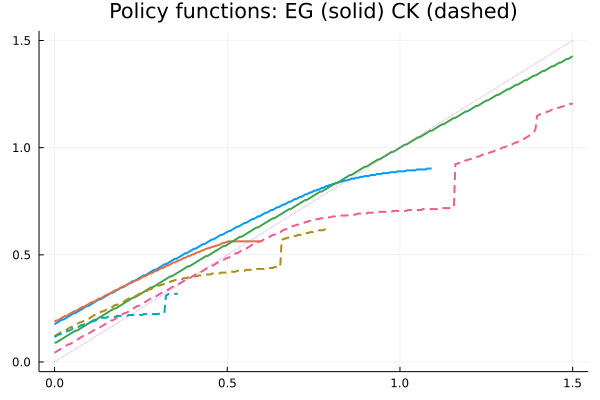

In [6]:
let yi = 100, ylow = 1
    yhigh = length(get_y_grid(mEG))
    b_grid = get_b_grid(mEG)
    mCKb_pol = get_b_pol(mCK)
    mEGb_pol = get_b_pol(mEG)
    
    out_low = [ 
        all_default_at(mEG, i, ylow) ? missing : b_grid[mEGb_pol[i, ylow][end].idx]  
        for i in eachindex(b_grid)
    ]
    out_high = [ 
        all_default_at(mEG, i, yhigh) ? missing : b_grid[mEGb_pol[i, yhigh][1].idx]  
        for i in eachindex(b_grid)
    ]
    out_mid = [ 
        all_default_at(mEG, i, yi) ? missing : b_grid[mEGb_pol[i, yi][end].idx]  
        for i in eachindex(b_grid)
    ]
    
    out_low_CK = [ 
        all_default_at(mCK, i, ylow) ? missing : b_grid[mCKb_pol[i, ylow][end].idx]  
        for i in eachindex(b_grid)
    ]
    out_high_CK = [ 
        all_default_at(mCK, i, yhigh) ? missing : b_grid[mCKb_pol[i, yhigh][1].idx]  
        for i in eachindex(b_grid)
    ]
    out_mid_CK = [ 
        all_default_at(mCK, i, yi) ? missing : b_grid[mCKb_pol[i, yi][end].idx]  
        for i in eachindex(b_grid)
    ]

    plot(b_grid, out_mid, lw = 2)
    plot!(b_grid, out_low, lw = 2)
    plot!(b_grid, out_high, lw = 2)

    plot!([0, 1.5], [0, 1.5], lw = 1, ls = :dot)
    plot!(title = "Policy functions: EG (solid) CK (dashed)")

    plot!(b_grid, out_mid_CK, lw = 2, ls = :dash)
    plot!(b_grid, out_low_CK, lw = 2, ls = :dash)
    plot!(b_grid, out_high_CK, lw = 2, ls = :dash)

end


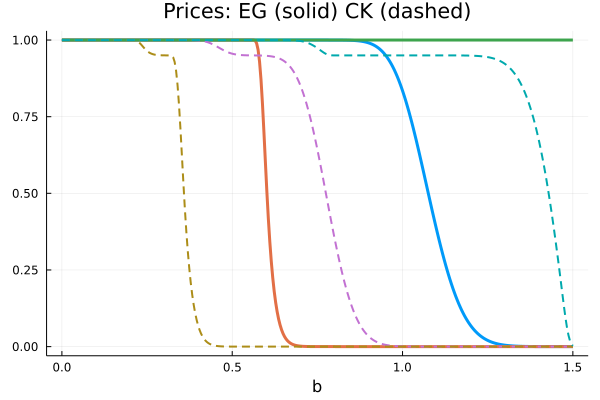

In [7]:
let 
    b_grid = get_b_grid(mEG)
    qEG = get_q(mEG)
    qCK = get_q(mCK)
    
    plot(b_grid, qEG[:, 100], lw = 3) 
    plot!(b_grid, qEG[:, 1], lw = 3, title = "Prices: EG (solid) CK (dashed)", xlabel = "b") 
    plot!(b_grid, qEG[:, end], lw = 3) 
    
    plot!(b_grid, qCK[:, 100], lw = 2, ls = :dash) 
    plot!(b_grid, qCK[:, 1], lw =  2, ls = :dash) 
    plot!(b_grid, qCK[:, end], lw = 2, ls = :dash) 
end 

## Long Bonds

In [8]:
mEGLB, mCKLB = let
    R = 1.01
    β = 0.9540232420
    pref = Preferences(β = β, u = make_CRRA(ra = 2))
    y = discretize(YProcess(n = 200, ρ = 0.948503, std = 0.027092, μ = 0.0, span = 3.0, tails = false))
    m = MTruncatedNormal(; std = 0.01, span = 2.0, quadN = 100)
    penalty = DefCosts(pen1 = -0.1881927550, pen2 = 0.2455843389, quadratic = true, reentry = 0.0385)
    
    bond = Bond(n = 350, min = 0.0, max = 1.5, κ = 0.03, λ = 0.2) 
    
    eg = LTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R
    )

    ck = CKLTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R,
        η = 0.05
    )
        
    (generate_workspace(eg),  generate_workspace(ck))
end;

In [9]:
@time solve!(mEGLB; max_iters = 2000, g = 1.0, err = 1e-7, print_every = 50)
@time solve!(mCKLB; max_iters = 2000, g = 1.0, err = 1e-7, print_every = 50)

1: (v = 1.576132156021231, q = 0.6218970800204663, vD = 0.5719930693249715)
51: (v = 0.01619776221542324, q = 0.20716663670477342, vD = 0.0028614094135548385)
101: (v = 0.004632309306021654, q = 0.039672801399612045, vD = 0.001980424393021707)
151: (v = 0.0009727786571609442, q = 0.006713782399878965, vD = 0.0004891120236401036)
201: (v = 0.0001842163693801524, q = 0.0011741271291828559, vD = 0.00010238210828816818)
251: (v = 3.308973175819574e-5, q = 0.00020721961173109094, vD = 1.9186285690864224e-5)
301: (v = 5.925818591379084e-6, q = 3.6372274299312224e-5, vD = 3.4583466259618945e-6)
351: (v = 1.0550829649957905e-6, q = 6.465948342526673e-6, vD = 6.160754786321831e-7)
401: (v = 1.873345958358641e-7, q = 1.1469042756617753e-6, vD = 1.0946105177822574e-7)
451: (v = 3.3240056040995114e-8, q = 2.0340097517390632e-7, vD = 1.9429752029509473e-8)
472: (v = 1.6077606801445654e-8, q = 9.836888159586721e-8, vD = 9.398714695407762e-9)
Converged.
 24.462005 seconds (3.19 k allocations: 554.312

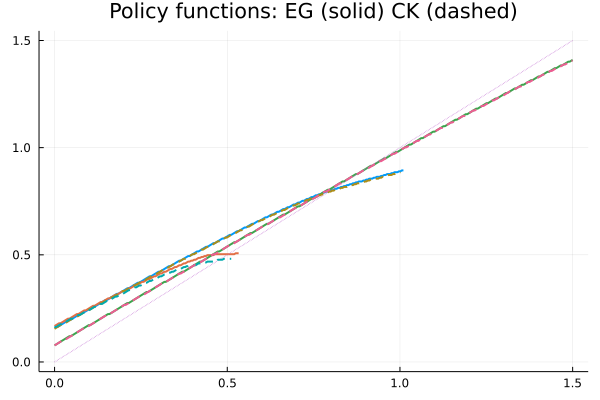

In [10]:
let yi = 100, ylow = 1, mEG = mEGLB, mCK = mCKLB, 
    yhigh = length(get_y_grid(mEG))
    b_grid = get_b_grid(mEG)
    mCKb_pol = get_b_pol(mCK)
    mEGb_pol = get_b_pol(mEG)
    
    out_low = [ 
        all_default_at(mEG, i, ylow) ? missing : b_grid[mEGb_pol[i, ylow][end].idx]  
        for i in eachindex(b_grid)
    ]
    out_high = [ 
        all_default_at(mEG, i, yhigh) ? missing : b_grid[mEGb_pol[i, yhigh][1].idx]  
        for i in eachindex(b_grid)
    ]
    out_mid = [ 
        all_default_at(mEG, i, yi) ? missing : b_grid[mEGb_pol[i, yi][end].idx]  
        for i in eachindex(b_grid)
    ]
    
    out_low_CK = [ 
        all_default_at(mCK, i, ylow) ? missing : b_grid[mCKb_pol[i, ylow][end].idx]  
        for i in eachindex(b_grid)
    ]
    out_high_CK = [ 
        all_default_at(mCK, i, yhigh) ? missing : b_grid[mCKb_pol[i, yhigh][1].idx]  
        for i in eachindex(b_grid)
    ]
    out_mid_CK = [ 
        all_default_at(mCK, i, yi) ? missing : b_grid[mCKb_pol[i, yi][end].idx]  
        for i in eachindex(b_grid)
    ]

    plot(b_grid, out_mid, lw = 2)
    plot!(b_grid, out_low, lw = 2)
    plot!(b_grid, out_high, lw = 2)

    plot!([0, 1.5], [0, 1.5], lw = 1, ls = :dot)
    plot!(title = "Policy functions: EG (solid) CK (dashed)")

    plot!(b_grid, out_mid_CK, lw = 2, ls = :dash)
    plot!(b_grid, out_low_CK, lw = 2, ls = :dash)
    plot!(b_grid, out_high_CK, lw = 2, ls = :dash)

end


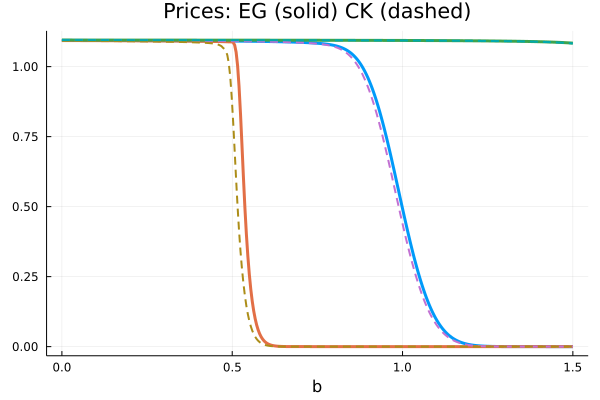

In [11]:
let mEG = mEGLB, mCK = mCKLB
    b_grid = get_b_grid(mEG)
    qEG = get_q(mEG)
    qCK = get_q(mCK)
    
    plot(b_grid, qEG[:, 100], lw = 3) 
    plot!(b_grid, qEG[:, 1], lw = 3, title = "Prices: EG (solid) CK (dashed)", xlabel = "b") 
    plot!(b_grid, qEG[:, end], lw = 3) 
    
    plot!(b_grid, qCK[:, 100], lw = 2, ls = :dash) 
    plot!(b_grid, qCK[:, 1], lw =  2, ls = :dash) 
    plot!(b_grid, qCK[:, end], lw = 2, ls = :dash) 
end 

## No persistent income shocks

### One period

In [12]:
detEG, detCK = let
    R = 1.01
    β = 0.9540232420
    pref = Preferences(β = β, u = make_CRRA(ra = 2))
    y = discretize(YProcess(n = 1, ρ = 0.948503, std = 0.0, μ = 0.0, span = 3.0, tails = false))
    m = MTruncatedNormal(; std = 0.0001, span = 2.0, quadN = 100)
    penalty = DefCosts(pen1 = -0.1881927550, pen2 = 0.2455843389, quadratic = true, reentry = 0.0385)
    
    bond = Bond(n = 350, min = 0.0, max = 3.0, κ = 0.03, λ = 1.0)

    eg = LTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R
    )

    ck = CKLTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R, 
        η = 0.05
    )

    generate_workspace(eg), generate_workspace(ck)
end;

In [13]:
@time solve!(detEG; max_iters = 2000, g = 1.0, err = 1e-7, print_every = 50)
@time solve!(detCK; max_iters = 2000, g = 1.0, err = 1e-7, print_every = 50)

1: (v = 0.7536585364697004, q = 0.0, vD = 0.048640530609162624)
51: (v = 0.018014559147591314, q = 1.0198019801980198, vD = 0.002729948234986068)
101: (v = 0.006287890206859714, q = 2.220446049250313e-16, vD = 0.0027132786327470626)
151: (v = 0.001706696682457931, q = 0.007333393560170449, vD = 0.0008098688587629965)
201: (v = 0.0005217122951215458, q = 0.0, vD = 0.00018440638288907962)
251: (v = 4.958825542900058e-5, q = 0.0, vD = 4.3140316812184665e-5)
301: (v = 4.7133163292301106e-6, q = 0.0, vD = 4.627250032029906e-6)
351: (v = 4.4799622500590885e-7, q = 0.0, vD = 4.4684741240530457e-7)
383: (v = 9.934841571634934e-8, q = 0.0, vD = 9.927587996116927e-8)
Converged.
  1.757393 seconds (3.18 M allocations: 170.824 MiB, 3.57% gc time)
1: (v = 0.7536585364697004, q = 0.050990099009901035, vD = 0.048640530609162624)
51: (v = 0.014729464977211393, q = 0.0, vD = 0.004468332472654879)
101: (v = 0.0008642964528071673, q = 0.0, vD = 0.0007934325311111934)
151: (v = 8.215055244775726e-5, q = 0

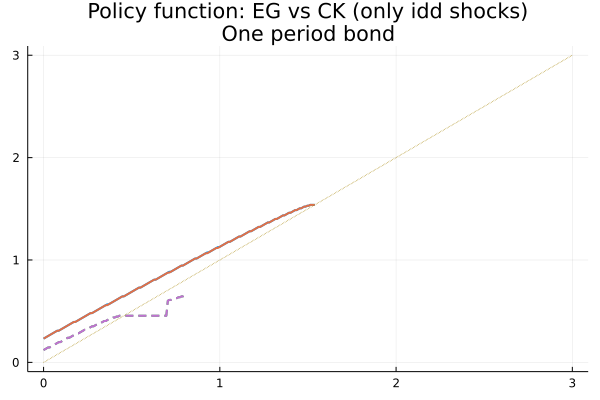

In [14]:
let yi = 1, ylow = 1, mCK = detCK, mEG = detEG
    b_grid = get_b_grid(mCK) 
    mCKb_pol = get_b_pol(mCK)
    mEGb_pol = get_b_pol(mEG)

    outEG_high = [ 
        all_default_at(mEG, i, yi) ? missing : b_grid[mEGb_pol[i, yi][end].idx]  
        for i in eachindex(b_grid)
    ]
    outEG_low = [ 
        all_default_at(mEG, i, yi) ? missing : b_grid[mEGb_pol[i, yi][1].idx]  
        for i in eachindex(b_grid)
    ]


    outCK_high = [ 
        all_default_at(mCK, i, yi) ? missing : b_grid[mCKb_pol[i, yi][end].idx]  
        for i in eachindex(b_grid)
    ]

    outCK_low = [ 
        all_default_at(mCK, i, yi) ? missing : b_grid[mCKb_pol[i, yi][1].idx]  
        for i in eachindex(b_grid)
    ]

    plot(b_grid, outEG_high, lw = 2)
    plot!(b_grid, outEG_low, lw = 2)

    plot!(b_grid, outCK_high, lw = 2, ls = :dash)
    plot!(b_grid, outCK_low, lw = 2, ls = :dash)

    plot!([0, last(b_grid)], [0, last(b_grid)], lw = 1, ls = :dot)
    plot!(title = "Policy function: EG vs CK (only idd shocks)\nOne period bond")

end


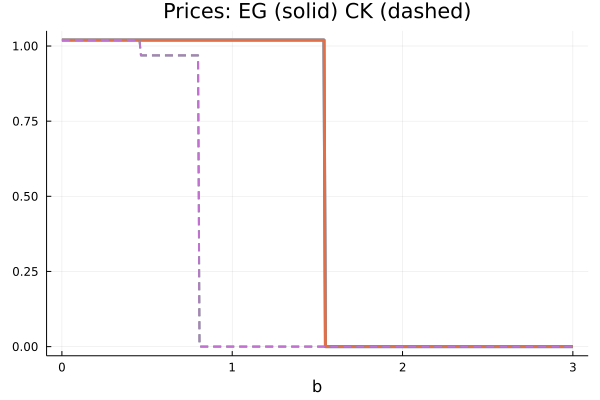

In [15]:
let  mCK = detCK, mEG = detEG
    b_grid = get_b_grid(mEG)
    qEG = get_q(mEG)
    qCK = get_q(mCK)
    
    plot(b_grid, qEG[:, 1], lw = 3, title = "Prices: EG (solid) CK (dashed)", xlabel = "b") 
    plot!(b_grid, qEG[:, end], lw = 3) 
    
    plot!(b_grid, qCK[:, 1], lw =  2, ls = :dash) 
    plot!(b_grid, qCK[:, end], lw = 2, ls = :dash) 
end 

### Long Bond

In [16]:
detEGLB, detCKLB = let
    R = 1.01
    β = 0.9540232420
    pref = Preferences(β = β, u = make_CRRA(ra = 2))
    y = discretize(YProcess(n = 1, ρ = 0.948503, std = 0.0, μ = 0.0, span = 3.0, tails = false))
    m = MTruncatedNormal(; std = 0.01, span = 10.0, quadN = 100)
    penalty = DefCosts(pen1 = -0.1881927550, pen2 = 0.2455843389, quadratic = true, reentry = 0.0385)
    
    bond = Bond(n = 350, min = 0.0, max = 2.0, κ = 0.03, λ = 0.05)

    eg = LTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R
    )

    ck = CKLTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R, 
        η = 0.05
    )

    generate_workspace(eg), generate_workspace(ck)
end;

In [17]:
@time solve!(detEGLB; max_iters = 2000, g = 1.0, err = 1e-7, print_every = 50)
@time solve!(detCKLB; max_iters = 10_000, g = 0.1, err = 1e-7, print_every = 50)

1: (v = 0.727270698677497, q = 0.0, vD = 0.04873594206064524)
51: (v = 0.01284465687144376, q = 0.5275548624684074, vD = 0.0015895920770425676)
101: (v = 0.004675627760590828, q = 0.13882157763406844, vD = 0.001969515526639043)
151: (v = 0.001247140140566927, q = 0.03162679794382495, vD = 0.0006156198299116511)
201: (v = 7.700936107823964e-5, q = 0.005975829336554939, vD = 5.4991100373769086e-5)
251: (v = 4.7552866021760565e-5, q = 0.0005566890784998724, vD = 5.5111146259889665e-6)
301: (v = 3.492394380799624e-6, q = 4.1952663782818256e-5, vD = 9.318176026340552e-7)
351: (v = 4.827400772455803e-7, q = 2.8656160189766133e-6, vD = 5.4523184189747553e-8)
401: (v = 3.738518827844928e-8, q = 1.5006069375989028e-7, vD = 4.690832611231599e-9)
402: (v = 3.530799119744188e-8, q = 3.808123683057829e-8, vD = 2.929713360799724e-9)
Converged.
  2.484959 seconds (3.84 k allocations: 369.266 KiB)
1: (v = 0.6545436288097477, q = 2.220446049250313e-16, vD = 0.04386234785458143)
51: (v = 0.0848302051263

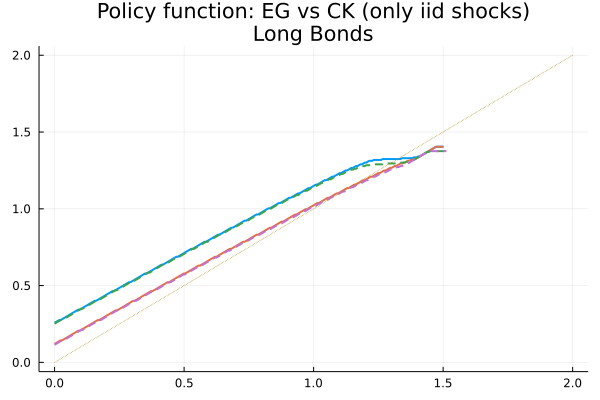

In [18]:
let yi = 1, ylow = 1, mCK = detCKLB, mEG = detEGLB
    b_grid = get_b_grid(mCK) 
    mCKb_pol = get_b_pol(mCK)
    mEGb_pol = get_b_pol(mEG)
    
    outEG_high = [ 
        all_default_at(mEG, i, yi) ? missing : b_grid[mEGb_pol[i, yi][end].idx]  
        for i in eachindex(b_grid)
    ]
    outEG_low = [ 
        all_default_at(mEG, i, yi) ? missing : b_grid[mEGb_pol[i, yi][1].idx]  
        for i in eachindex(b_grid)
    ]


    outCK_high = [ 
        all_default_at(mCK, i, yi) ? missing : b_grid[mCKb_pol[i, yi][end].idx]  
        for i in eachindex(b_grid)
    ]

    outCK_low = [ 
        all_default_at(mCK, i, yi) ? missing : b_grid[mCKb_pol[i, yi][1].idx]  
        for i in eachindex(b_grid)
    ]

    plot(b_grid, outEG_high, lw = 2)
    plot!(b_grid, outEG_low, lw = 2)

    plot!(b_grid, outCK_high, lw = 2, ls = :dash)
    plot!(b_grid, outCK_low, lw = 2, ls = :dash)

    plot!([0, last(b_grid)], [0, last(b_grid)], lw = 1, ls = :dot)
    plot!(title = "Policy function: EG vs CK (only iid shocks)\nLong Bonds")

end


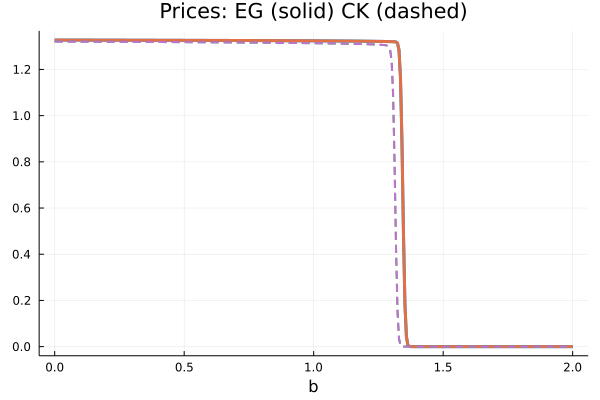

In [19]:
let  mCK = detCKLB, mEG = detEGLB
    b_grid = get_b_grid(mEG)
    qEG = get_q(mEG)
    qCK = get_q(mCK)
    
    plot(b_grid, qEG[:, 1], lw = 3, title = "Prices: EG (solid) CK (dashed)", xlabel = "b") 
    plot!(b_grid, qEG[:, end], lw = 3) 
    
    plot!(b_grid, qCK[:, 1], lw =  2, ls = :dash) 
    plot!(b_grid, qCK[:, end], lw = 2, ls = :dash) 
end 